# Preprocessing NYT Article Content and Using Topic Modeling to Identify topics throughout the corpus using NMF. 

## First, reload the dataframe containing the corpus from pickle file

In [2]:
import pandas as pd
import numpy as np
import sklearn.feature_extraction.text as text
from sklearn import decomposition
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
from nltk.tokenize import wordpunct_tokenize
import pickle

In [3]:
with open('nyt_markets_complete_df.pickle', 'rb') as dff:
    nyt_markets_df = pickle.load(dff)

In [4]:
nyt_markets_df

index                                     0  \
0          0                                   NaN   
1          0                                   NaN   
2          0                                   NaN   
3          0                                   NaN   
4          0  UPDATED December 2, 2016Dec. 1, 2016   
...      ...                                   ...   
13921      0                                   NaN   
13922      0                                   NaN   
13923      0                                   NaN   
13924      0                                   NaN   
13925      0                                   NaN   

                                                       1  \
0      https://www.nytimes.com/2019/05/29/business/de...   
1      https://www.nytimes.com/2017/12/03/business/me...   
2      https://www.nytimes.com/2016/02/05/business/en...   
3      https://www.nytimes.com/2016/01/31/nytnow/your...   
4      https://www.nytimes.com/interactive/2016/12/02...   
...                                                  ...   
13921  https://www.nytimes.com/2018/10/15/briefing/ba...   
13922  https://www.nytimes.com/2017/02/09/business/de...   
13923  https://www.nytimes.com/2016/09/06/world/europ...   
13924  https://www.nytimes.com/2018/04/25/business/de...   
13925  https://www.nytimes.com/2017/03/29/opinion/how...   

                                                       2  
0      Good Wednesday. (Want this by email? Sign up h...  
1      Dozens of people were gathered on a Manhattan ...  
2      LONDON — Royal Dutch Shell became the latest b...  
3      Here are the week’s top stories.1. The preside...  
4                                                    NaN  
...                                                  ...  
13921  (Want to get this briefing by email? Here’s th...  
13922  As a college student in the early 1990s, Charl...  
13923  LONDON — Outlining the first, tentative detail...  
13924  Good Wednesday. Here’s what we’re watching:• F...  
13925  SEOUL, South Korea — As President Trump strugg...  

[13926 rows x 4 columns]

## First step will be to rename the dataframe columns and extract the date from the URL

In [5]:
nyt_markets_df.columns = ['index','date', 'url','article']

In [7]:
import re, datetime
def regex_date(string):
    try:
        match = re.search('\d{4}/\d{2}/\d{2}',string)
        date = datetime.datetime.strptime(match.group(), '%Y/%m/%d').date()
        return date
    except:
        return None

In [8]:
nyt_markets_df['url_date'] = nyt_markets_df['url'].apply(regex_date)

In [9]:
nyt_markets_df.head()

index                                  date  \
0      0                                   NaN   
1      0                                   NaN   
2      0                                   NaN   
3      0                                   NaN   
4      0  UPDATED December 2, 2016Dec. 1, 2016   

                                                 url  \
0  https://www.nytimes.com/2019/05/29/business/de...   
1  https://www.nytimes.com/2017/12/03/business/me...   
2  https://www.nytimes.com/2016/02/05/business/en...   
3  https://www.nytimes.com/2016/01/31/nytnow/your...   
4  https://www.nytimes.com/interactive/2016/12/02...   

                                             article    url_date  
0  Good Wednesday. (Want this by email? Sign up h...  2019-05-29  
1  Dozens of people were gathered on a Manhattan ...  2017-12-03  
2  LONDON — Royal Dutch Shell became the latest b...  2016-02-05  
3  Here are the week’s top stories.1. The preside...  2016-01-31  
4                                                NaN  2016-12-02

### We will go ahead and drop the 'index' and 'date' column. Index column is unnecessary, while extracting the date of the article from the URL proved more fruitful than scraping the date. 

In [10]:
columns = ['index','date']
nyt_markets_df.drop(columns, axis=1, inplace=True)

### Given a cleaner dataframe, we will now remove rows in which the scraper was unable to pull article content

In [12]:
nyt_markets_df_clean = nyt_markets_df.dropna(subset=['article'])

In [13]:
print("Corpus is now",nyt_markets_df_clean.shape[0],"documents long")

Corpus is now 13496 documents long


# The below plot shows the distribution of article length in terms of 'words' throughout the ~13K article corpus. 

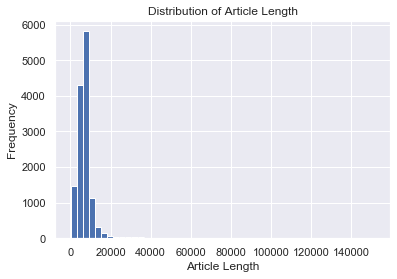

In [14]:

# Import seaborn for data visualization# Impor 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

article_lengths = nyt_markets_df_clean.article.str.len()

ax = article_lengths.hist(bins=50)
ax.set(xlabel='Article Length', ylabel='Frequency', 
       title='Distribution of Article Length');

In [15]:
import re
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

In [16]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [26]:
nyt_markets_df_clean.iloc[:,2]

0        2019-05-29
1        2017-12-03
2        2016-02-05
3        2016-01-31
5        2016-06-24
            ...    
13921    2018-10-15
13922    2017-02-09
13923    2016-09-06
13924    2018-04-25
13925    2017-03-29
Name: url_date, Length: 13496, dtype: object

In [28]:
nyt_markets_df_clean['article_contractions']=pd.Series()
for i in range(len(nyt_markets_df_clean)):
    nyt_markets_df_clean.iloc[i,3] = expandContractions(nyt_markets_df_clean.iloc[i,1])


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

In [29]:
nyt_markets_df_clean

url  \
0      https://www.nytimes.com/2019/05/29/business/de...   
1      https://www.nytimes.com/2017/12/03/business/me...   
2      https://www.nytimes.com/2016/02/05/business/en...   
3      https://www.nytimes.com/2016/01/31/nytnow/your...   
5      https://www.nytimes.com/2016/06/24/world/middl...   
...                                                  ...   
13921  https://www.nytimes.com/2018/10/15/briefing/ba...   
13922  https://www.nytimes.com/2017/02/09/business/de...   
13923  https://www.nytimes.com/2016/09/06/world/europ...   
13924  https://www.nytimes.com/2018/04/25/business/de...   
13925  https://www.nytimes.com/2017/03/29/opinion/how...   

                                                 article    url_date  \
0      Good Wednesday. (Want this by email? Sign up h...  2019-05-29   
1      Dozens of people were gathered on a Manhattan ...  2017-12-03   
2      LONDON — Royal Dutch Shell became the latest b...  2016-02-05   
3      Here are the week’s top stories.1. The preside...  2016-01-31   
5      BURG MIGHEIZIL, Egypt — In the raggedy fishing...  2016-06-24   
...                                                  ...         ...   
13921  (Want to get this briefing by email? Here’s th...  2018-10-15   
13922  As a college student in the early 1990s, Charl...  2017-02-09   
13923  LONDON — Outlining the first, tentative detail...  2016-09-06   
13924  Good Wednesday. Here’s what we’re watching:• F...  2018-04-25   
13925  SEOUL, South Korea — As President Trump strugg...  2017-03-29   

                                    article_contractions  
0      Good Wednesday. (Want this by email? Sign up h...  
1      Dozens of people were gathered on a Manhattan ...  
2      LONDON — Royal Dutch Shell became the latest b...  
3      Here are the week’s top stories.1. The preside...  
5      BURG MIGHEIZIL, Egypt — In the raggedy fishing...  
...                                                  ...  
13921  (Want to get this briefing by email? Here’s th...  
13922  As a college student in the early 1990s, Charl...  
13923  LONDON — Outlining the first, tentative detail...  
13924  Good Wednesday. Here’s what we’re watching:• F...  
13925  SEOUL, South Korea — As President Trump strugg...  

[13496 rows x 4 columns]

In [30]:
article_list = []
for text in nyt_markets_df_clean.article_contractions:
    article_list.append(text)
    


In [31]:
article_list[0][0:100]

'Good Wednesday. (Want this by email? Sign up here.)Both inside and outside the White House, there ar'

In [32]:
article_list[13495][0:100]

'SEOUL, South Korea — As President Trump struggles to devise a North Korea strategy, one country’s vo'

## The below cell uses the nltk library to lemmatize the corpus that currently exists in the clean_book_list object. Once the lemmatization is performed, the corpus is stored in a new object called clean_books

In [33]:
clean_book_list = article_list

lemma=nltk.stem.WordNetLemmatizer()

lemma_books = []
for book in clean_book_list:
    lemma_book = [lemma.lemmatize(word) for word in wordpunct_tokenize(book)]
    lemma_book = (' ').join(lemma_book)
    lemma_books.append(lemma_book)

In [35]:
clean_books = lemma_books
clean_books[0][0:100]

'Good Wednesday . ( Want this by email ? Sign up here .) Both inside and outside the White House , th'

## The below cell performs other text preprocessing steps that are required by conventional NLP projects. Using sklearn, the clean_books object is used in built in functions to remove stop_words, vectorize using a TF-IDF vectorizer, and create a vocabulary for the corpus using the vectorize.get_feature_names() function. 

In [38]:
from sklearn.feature_extraction import text
from nltk.corpus import stopwords


my_stop_words = set(stopwords.words('english'))

ngrams=1

vectorizer = text.TfidfVectorizer(
    stop_words=my_stop_words, ngram_range=(1,ngrams), min_df=10, max_df=.7, token_pattern="\\b[a-z][a-z]+\\b")
dtm = vectorizer.fit_transform(clean_books).toarray()
vocab = np.array(vectorizer.get_feature_names())
dtm.shape

(13496, 27627)

In [39]:
print("Vocabulary for the corpus is ",len(vocab),"long")

Vocabulary for the corpus is  27627 long


# We will now proceed with our NLP modeling

## First, we will implement NMF topic modeling as per below:

In [52]:
num_topics = 15
NMFmodel = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = NMFmodel.fit_transform(dtm)
pickle.dump(doctopic, open("nyt_markets_dtm_doctopic", 'wb'), protocol=4)


In [53]:
num_top_words = 20
topic_words = []
word_weights = []
for topic in NMFmodel.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
    word_weights.append([topic[i] for i in word_idx])

# As we see by the output, the NMF model using 15 topics generated clearly separable topics. 

In [54]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: briefing times morning york today president trump day sign north korea woman updated email russia
Topic 1: bank financial deutsche banking loan billion central lender trading credit regulator currency goldman debt crisis
Topic 2: trade tariff trump states united american administration steel agreement deal import president mexico china war
Topic 3: fed rate inflation powell economy interest economic yellen policy growth reserve central increase federal monetary
Topic 4: health insurance care insurer obamacare plan affordable coverage premium bill act subsidy law people medicaid
Topic 5: bond million refinancing revenue obligation competitive general district tax county authority unlimited markets morgan school
Topic 6: ms city home art people food work restaurant time family building school room woman apartment
Topic 7: oil energy saudi barrel price gas iran production arabia opec coal aramco crude producer sanction
Topic 8: european britain union brexit europe british party i

In [55]:
pickle.dump(doctopic, open("nyt_markets_dtm_doctopic", 'wb'), protocol=4)


In [146]:
len(doctopic)

13496

# The below piece of code loops through the doctopic object, and takes the index of max value from each item of the doctopic, and then assigns that index value to each article to represent the topic number of the article. This is then graphed using the Hist function to observe the frequency of topics throughout the corpus. 

In [141]:
import operator
blank_list = []
nyt_markets_df_clean['nmf_topic'] = pd.Series()
for i in range(len(doctopic)):
    index, value = max(enumerate(doctopic[i]), key=operator.itemgetter(1))
    blank_list.append(index)
    nyt_markets_df_clean.loc[i,'nmf_topic'] = blank_list[i]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [151]:
nyt_markets_df_clean_nmf = nyt_markets_df_clean.dropna()

Text(0.5, 0, 'Topic')

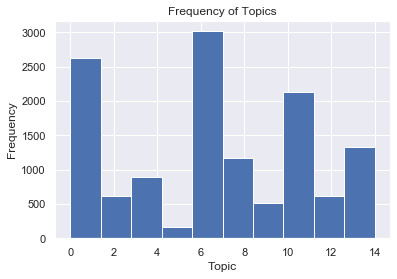

In [152]:
nmf_topic_historgram = nyt_markets_df_clean_nmf['nmf_topic'].plot(kind='hist',title='Frequency of Topics')
plt.xlabel('Topic')

In [155]:
def filter_n_graf(df):
    for i in range(0,15):
        df1 = df[(df['nmf_topic']==i)]
        df0 = df1.groupby(['url_date']).nmf_topic.agg(['count'])
        df0.plot.line(figsize=(8,8))
        plt.title('Count of Topic ' + str(i))

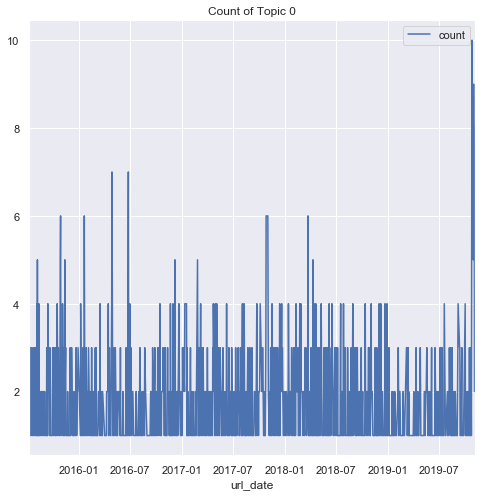

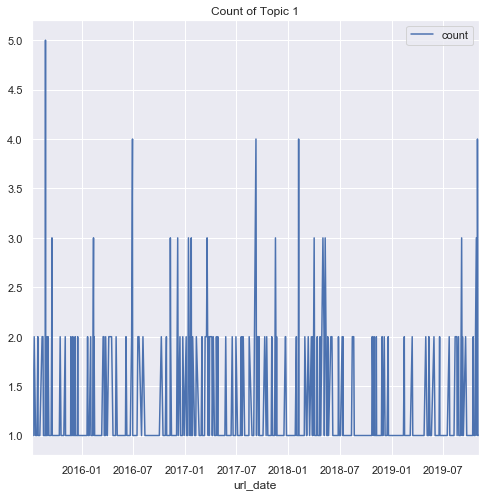

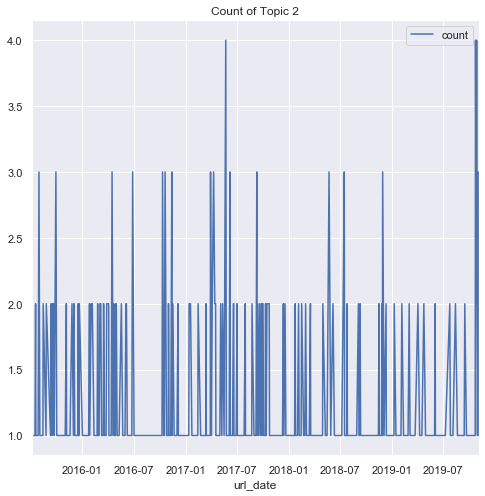

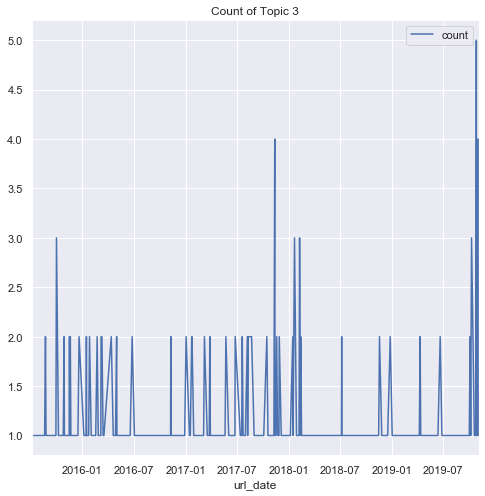

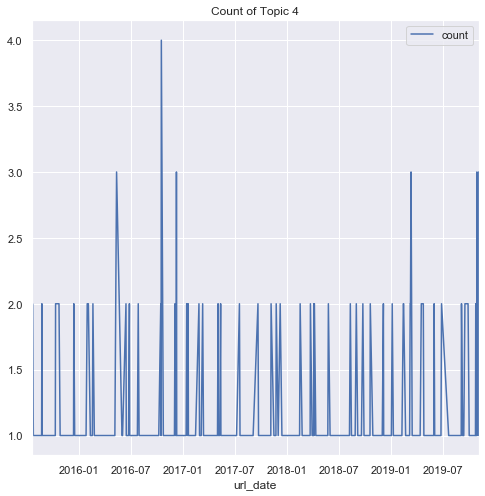

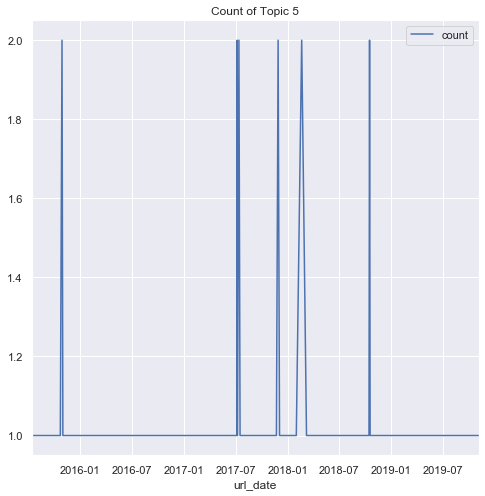

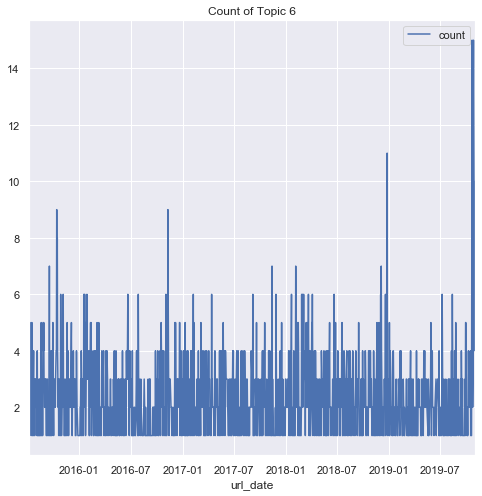

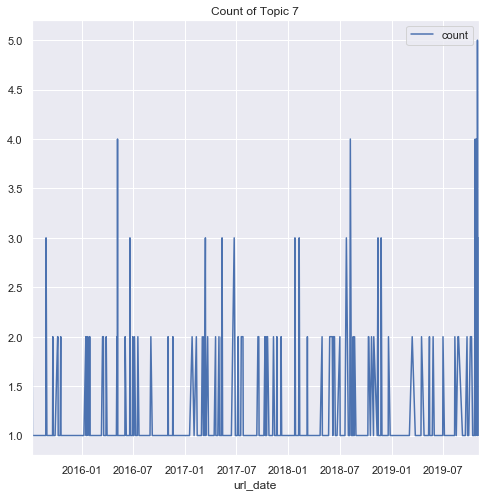

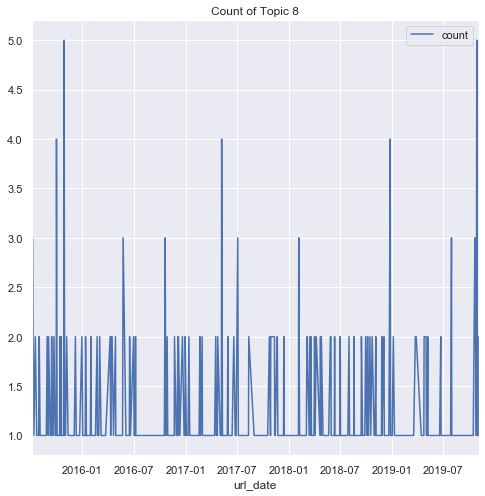

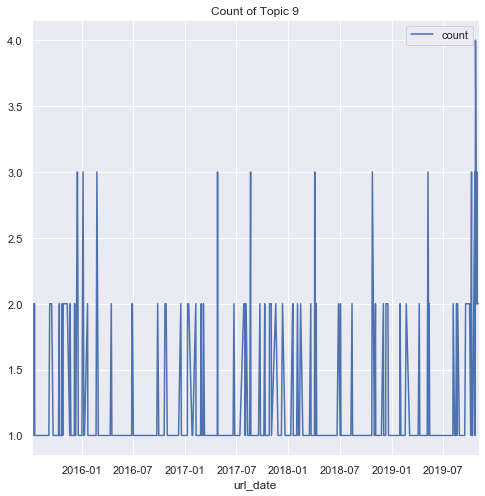

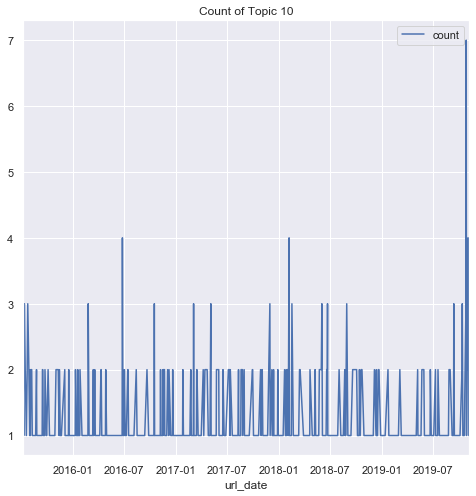

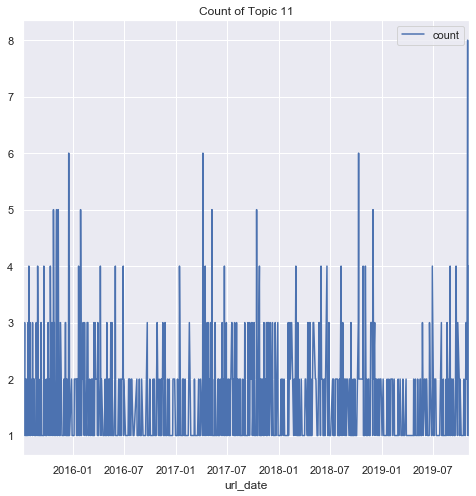

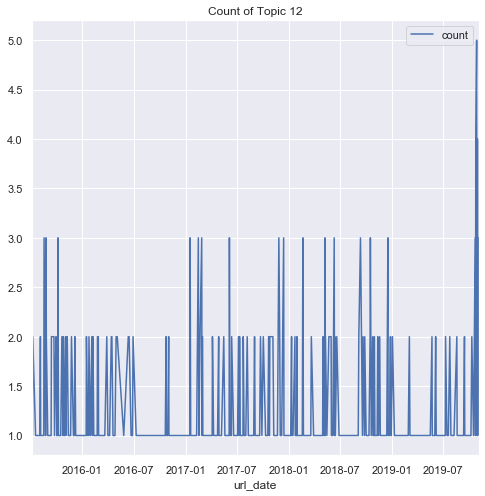

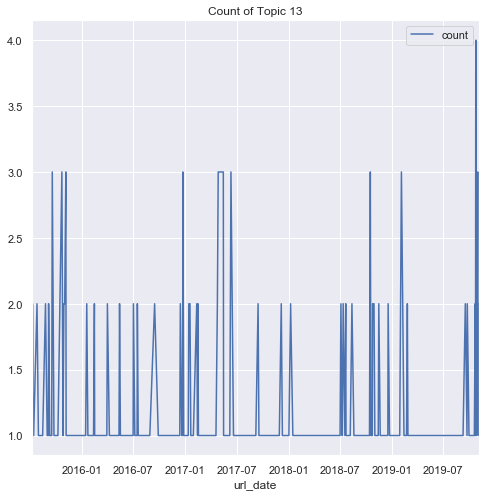

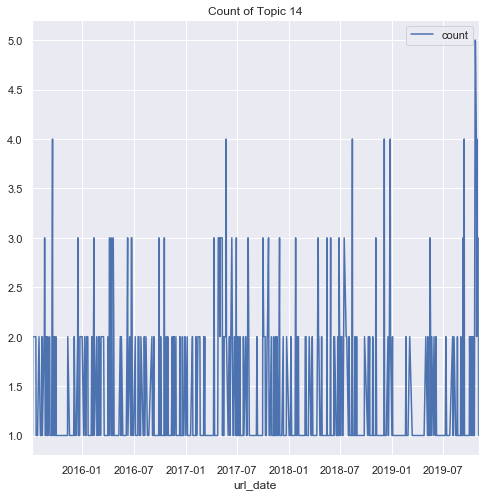

In [156]:
filter_n_graf(nyt_markets_df_clean_nmf)

# With NMF Topic Modeling Complete, we will now go ahead and see if the results differ using LDA in a subsequent notebook 


In [157]:
clean_books

['Good Wednesday . ( Want this by email ? Sign up here .) Both inside and outside the White House , there are growing call for a weakening of China ’ s link to U . S . financial market , Keith Bradsher and Ana Swanson of the NYT report .• “ Some trade expert and others urging the Trump administration to keep a hawkish stance are discussing whether the White House should curb China ’ s access to Wall Street .”• A bipartisan group of senator urged the administration last month to increase disclosure requirement for Chinese company listed in the U . S . if they pose national security risk or are complicit in human right abuse .• Steve Bannon , Mr . Trump ’ s former chief strategist , ha said that a lack of transparency about the ultimate owner of Chinese company is problematic .• “ The New York Stock Exchange and Nasdaq are breaching their fiduciary responsibility to institutional investor , the pension fund of hardworking Americans ,” Mr . Bannon said . “ It ’ s outrageous . All of it sh